In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import pandas as pd
import cv2


C:\Users\Usuario\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


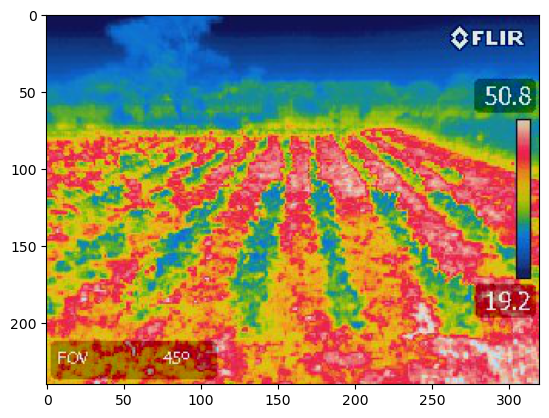

In [2]:
I = imread('../data/images/image_1_IR.jpg')
plt.imshow(I)

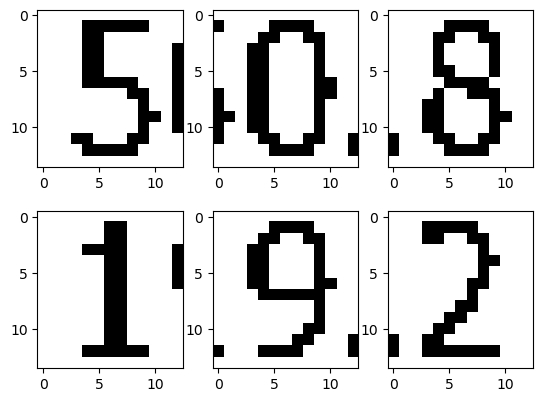

In [3]:
t_max_1=I[46:60,282:295]
t_max_2=I[46:60,291:304]
t_max_3=I[46:60,304:317]
t_min_1=I[179:193,282:295]
t_min_2=I[179:193,291:304]
t_min_3=I[179:193,304:317]

_ , t_max_1=cv2.threshold(t_max_1.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
_ , t_max_2=cv2.threshold(t_max_2.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
_ , t_max_3=cv2.threshold(t_max_3.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
_ , t_min_1=cv2.threshold(t_min_1.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
_ , t_min_2=cv2.threshold(t_min_2.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
_ , t_min_3=cv2.threshold(t_min_3.mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 

fig, ax = plt.subplots(2,3)
ax[0,0].imshow(t_max_1, cmap='gray')
ax[0,1].imshow(t_max_2, cmap='gray')
ax[0,2].imshow(t_max_3, cmap='gray')
ax[1,0].imshow(t_min_1, cmap='gray')
ax[1,1].imshow(t_min_2, cmap='gray')
ax[1,2].imshow(t_min_3, cmap='gray')




In [4]:
base_digitos = {
    "0": imread('../data/base_digitos/base_0.png'),
    "1": imread('../data/base_digitos/base_1.png'),
    "2": imread('../data/base_digitos/base_2.png'),
    "3": imread('../data/base_digitos/base_3.png'),
    "4": imread('../data/base_digitos/base_4.png'),
    "5": imread('../data/base_digitos/base_5.png'),
    "6": imread('../data/base_digitos/base_6.png'),
    "7": imread('../data/base_digitos/base_7.png'),
    "8": imread('../data/base_digitos/base_8.png'),
    "9": imread('../data/base_digitos/base_9.png'),
}

In [5]:
def match_digit(img, base_digitos):
    puntajes = {}

    for i, digito in base_digitos.items():
        
        # Hacemos el matching
        resultado = cv2.matchTemplate(img.astype('uint8'), digito, cv2.TM_CCOEFF_NORMED)
        _, puntaje, _, _ = cv2.minMaxLoc(resultado)
        puntajes[i] = puntaje
    
    # Devolvemos el dígito con el score más alto
    return max(puntajes, key=puntajes.get)

In [6]:
d1_max=match_digit(t_max_1, base_digitos)
d2_max=match_digit(t_max_2, base_digitos)
d3_max=match_digit(t_max_3, base_digitos)
d1_min=match_digit(t_min_1, base_digitos)
d2_min=match_digit(t_min_2, base_digitos)
d3_min=match_digit(t_min_3, base_digitos)

t_max = float(d1_max + d2_max + '.' + d3_max)
t_min = float(d1_min + d2_min + '.' + d3_min)

print('Temperatura máxima: ' + str(t_max))
print('Temperatura mínima: ' + str(t_min))

Temperatura máxima: 50.8
Temperatura mínima: 19.2


In [7]:
perfil= I[72:167,310,:].astype(np.float32)
saltos= perfil.shape[0]-1
deltaT= (t_max-t_min)/saltos

In [8]:
lista_temperatura = np.round(t_max - np.arange(saltos+1) * deltaT, 2)

temp_dic={"Color RGB": perfil.astype(np.uint8).tolist(),
          "Temperatura (°C)": lista_temperatura}

df_temperatura = pd.DataFrame(temp_dic)

display(df_temperatura.head(10))

,Color RGB,Temperatura (°C)
0,"[210, 188, 149]",50.80
1,"[219, 178, 146]",50.46
2,"[220, 170, 147]",50.13
3,"[218, 162, 149]",49.79
4,"[220, 153, 147]",49.46
5,"[225, 140, 143]",49.12
6,"[225, 133, 134]",48.78
7,"[222, 131, 130]",48.45
8,"[201, 108, 126]",48.11
9,"[199, 100, 120]",47.77


In [9]:
# Dimensiones de la imagen de entrada
m, n, _ = I.shape
# Aplana la matriz a una lista de puntos para facilitar los cálculos
colores = I.reshape(-1, 1, 3).astype(np.float32)

# Calcula las distancias y encuentra el índice del punto más cercano
distancias = np.sqrt(np.sum((colores - perfil)**2, axis=2))
indices = np.argmin(distancias, axis=1)
# Reforma los índices a la forma original MxN
indices_m = indices.reshape(m, n)

temperatura = t_max - indices_m * deltaT


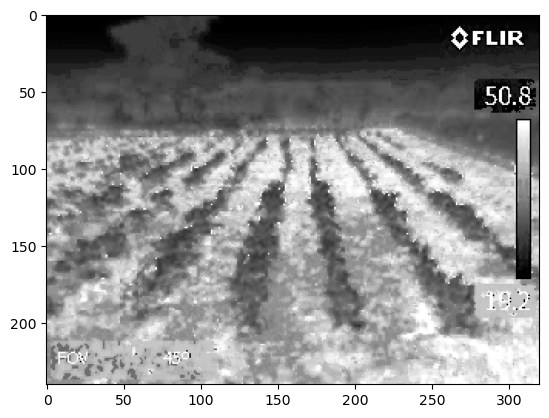

In [10]:
temperatura_grises = np.round((temperatura - t_min) / (t_max - t_min) * 255).astype(np.uint8)

plt.imshow(temperatura_grises, cmap='gray')

In [11]:
import openpyxl

In [12]:
def colorear(fila):
    # Toma una fila de un dataframe y devuelve una lista de estilos CSS
    # 'background-color' y 'color' para cada celda en la fila.
    rgb = fila['Color RGB']
    # Calcula la luminosidad del color
    luminosidad = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    # Si la luminosidad es baja, el color del texto será blanco. De lo contrario, será negro.
    color_texto = 'white' if luminosidad < 128 else 'black'
    color_fondo = f'rgb({rgb[0]}, {rgb[1]}, {rgb[2]})'
    return [f'background-color: {color_fondo}; color: {color_texto}' for _ in fila]

# Aplica la función 'colorear' a cada fila del dataframe
df_coloreado = df_temperatura.style.apply(colorear, axis=1).hide(axis="index")

# Muestra el dataframe coloreado
df_coloreado

Color RGB,Temperatura (°C)
"[210, 188, 149]",50.800000
"[219, 178, 146]",50.460000
"[220, 170, 147]",50.130000
"[218, 162, 149]",49.790000
"[220, 153, 147]",49.460000
"[225, 140, 143]",49.120000
"[225, 133, 134]",48.780000
"[222, 131, 130]",48.450000
"[201, 108, 126]",48.110000
"[199, 100, 120]",47.770000


A partir de esta LUT se puede tener el valor de temperatura en cada pixel como se hizo anteriormente. Formando una matriz de temperaturas.

In [13]:
def lut_temperatura(img, base_digitos):
    # Recorte de dígitos
    _ , t_max_1=cv2.threshold(img[46:60,282:295].mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
    _ , t_max_2=cv2.threshold(img[46:60,291:304].mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
    _ , t_max_3=cv2.threshold(img[46:60,304:317].mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
    _ , t_min_1=cv2.threshold(img[179:193,282:295].mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
    _ , t_min_2=cv2.threshold(img[179:193,291:304].mean(axis=2),190,255,cv2.THRESH_BINARY_INV) 
    _ , t_min_3=cv2.threshold(img[179:193,304:317].mean(axis=2),190,255,cv2.THRESH_BINARY_INV)
    
    # Detección de dígitos con template matching
    d1_max=match_digit(t_max_1, base_digitos)
    d2_max=match_digit(t_max_2, base_digitos)
    d3_max=match_digit(t_max_3, base_digitos)
    d1_min=match_digit(t_min_1, base_digitos)
    d2_min=match_digit(t_min_2, base_digitos)
    d3_min=match_digit(t_min_3, base_digitos)
    
    #Recomposición de temperatura
    t_max = float(d1_max + d2_max + '.' + d3_max)
    t_min = float(d1_min + d2_min + '.' + d3_min)
    
    #Generación de la LUT
    perfil= img[72:167,310,:].astype(np.float32)
    saltos= perfil.shape[0]-1
    deltaT= (t_max-t_min)/saltos
    lista_temperatura = np.round(t_max - np.arange(saltos+1) * deltaT, 2)
    temp_dic={"Color RGB": perfil.astype(np.uint8).tolist(),
          "Temperatura (°C)": lista_temperatura}
    df_temperatura = pd.DataFrame(temp_dic)
    
    return df_temperatura
    
    

In [14]:
display(lut_temperatura(I, base_digitos))

,Color RGB,Temperatura (°C)
0,"[210, 188, 149]",50.80
1,"[219, 178, 146]",50.46
2,"[220, 170, 147]",50.13
3,"[218, 162, 149]",49.79
4,"[220, 153, 147]",49.46
...,...,...
90,"[33, 59, 144]",20.54
91,"[28, 56, 130]",20.21
92,"[23, 51, 114]",19.87
93,"[15, 40, 94]",19.54
